### Настройка окружения

In [ ]:
! pip install torchkge -U
!pip install dill

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# переходим в нашу директорию
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
%cd '/content/drive/MyDrive/joie'

Mounted at /content/drive/
/content/drive/MyDrive/joie


In [ ]:
# для импорта модулей связанных с joie
import sys
sys.path.insert(0,'joie')

In [ ]:
# import torchkge
import torch
from torchkge.data_structures import KnowledgeGraph,SmallKG
import pandas as pd
import numpy as np
from torch import cuda

from joie.models import *
from joie.evaluation import *
from joie.trainer import *
from joie.utils import *

from torchkge.utils import MarginLoss
from torchkge.models.bilinear import DistMultModel, HolEModel
from torchkge.models.translation import TransEModel
from torchkge.evaluation import LinkPredictionEvaluator

/usr/local/lib/python3.10/dist-packages/torchkge/utils/data_redundancy.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Загрузка данных

In [ ]:
datasets = {data: 
            {
              type_kg : 
                to_structure_kg(f'data/{data}/{data}_{type_kg}.txt') for type_kg in ['insnet','ontonet','instype']
             } 
            for data in ['db']
          }

Получение train/test

In [ ]:
kg_insnet_train,kg_insnet_test = train_test_split_kg(datasets['db']['insnet'], test_size=0.1, type_split='size')
kg_ontonet_train,kg_ontonet_test = train_test_split_kg(datasets['db']['ontonet'], test_size=0.5, type_split='size')
kg_instype_train,kg_instype_test = train_test_split_kg(datasets['db']['instype'], test_size=0.1, type_split='size')

### JOIE TransE Cross Transformation

In [ ]:
joie_transe_ct = JOIE(kg_instance = datasets['db']['insnet'], 
                      kg_ontology = datasets['db']['ontonet'], 
                      kg_ins_type = datasets['db']['instype'],
    				entity_dim = 300, concept_dim = 50,
    				intra_view_model = 'transe', cross_view_model = 'ct',
    				margin_intra = 0.5, margin_cross = 0.5,**{'lr_instance':0.0005,'lr_ontology':0.0005,'lr_cross':0.0005})

trainer = TrainerJoie(joie = joie_transe_ct,
                       kg_instance = datasets['db']['insnet'],
                       kg_ontology = datasets['db']['ontonet'],  
                       kg_instype = datasets['db']['instype'],
        n_epochs = 100, n_batches = 300,alpha = 1, omega = 1,sampling_type='bern', use_cuda='all')


In [ ]:
trainer.run(120)

  0%|          | 0/100 [00:00<?, ?epoch/s]

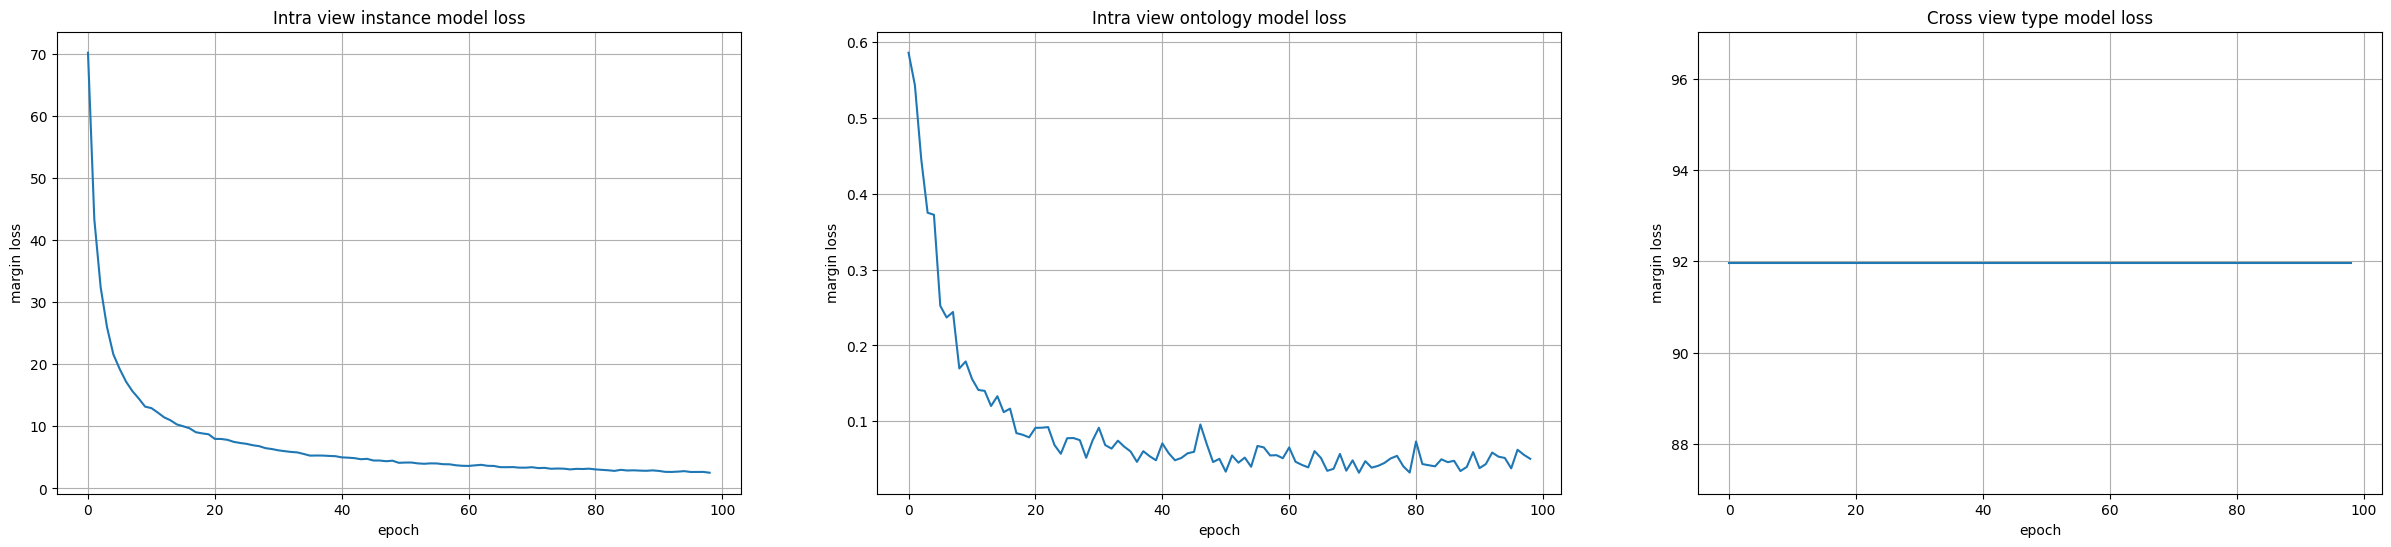

In [ ]:
trainer.plot_train_process()

In [ ]:
torch.cuda.empty_cache()
gc.collect()

23

In [ ]:
results_transe = joie_transe_ct.joie_performance(kg_insnet_test,
                                             kg_ontonet_test,
                                             kg_instype_test,64,50)

KG instance: Link prediction evaluation:   0%|          | 0/1029 [00:00<?, ?batch/s]

OutOfMemoryError: ignored

In [ ]:
results_transe

### JOIE DistMult Cross Transformation

In [ ]:
joie_distmult_ct = JOIE(kg_instance = datasets['db']['insnet'], 
                        kg_ontology = datasets['db']['ontonet'], 
                        kg_ins_type = datasets['db']['instype'],
    				entity_dim = 300, concept_dim = 50,
    				intra_view_model = 'distmult', cross_view_model = 'ct',
    				margin_intra = 0.5, margin_cross = 0.5,**{'lr_instance':0.0005,'lr_ontology':0.0005,'lr_cross':0.0005})

trainer = TrainerJoie(joie = joie_distmult_ct,
                       kg_instance = datasets['db']['insnet'],
                       kg_ontology = datasets['db']['ontonet'],  
                       kg_instype = datasets['db']['instype'],
        n_epochs = 100, n_batches = 300,alpha = 1, omega = 1,sampling_type='bern', use_cuda='all')


In [ ]:
trainer.run(100)
trainer.plot_train_process()
torch.cuda.empty_cache()

In [ ]:
results_distmult = joie_distmult_ct.joie_performance(kg_insnet_test,
                                             kg_ontonet_test,
                                             kg_instype_test,64,50)
results_distmult

### JOIE Hole Cross Transformation

In [ ]:
joie_hole_ct = JOIE(kg_instance = datasets['db']['insnet'], 
                    kg_ontology = datasets['db']['ontonet'], 
                    kg_ins_type = datasets['db']['instype'],
    				entity_dim = 300, concept_dim = 50,
    				intra_view_model = 'hole', cross_view_model = 'ct',
    				margin_intra = 0.5, margin_cross = 0.5,**{'lr_instance':0.0005,'lr_ontology':0.0005,'lr_cross':0.0005})

trainer = TrainerJoie(joie = joie_hole_ct,
                       kg_instance = datasets['db']['insnet'],
                       kg_ontology = datasets['db']['ontonet'], 
                       kg_instype = datasets['db']['instype'],
        n_epochs = 50, n_batches = 300,alpha = 1, omega = 1,sampling_type='bern', use_cuda='all')


In [ ]:
trainer.run(100)
trainer.plot_train_process()
torch.cuda.empty_cache()

In [ ]:
results_hole = joie_hole_ct.joie_performance(kg_insnet_test,
                                             kg_ontonet_test,
                                             kg_instype_test,64,50)
results_hole

### JOIE Complex Cross Transformation

In [ ]:
joie_complex_ct = JOIE(kg_instance = datasets['db']['insnet'], 
                      kg_ontology = datasets['db']['ontonet'], 
                      kg_ins_type = datasets['db']['instype'],
    				entity_dim = 300, concept_dim = 50,
    				intra_view_model = 'complex', cross_view_model = 'ct',
    				margin_intra = 0.5, margin_cross = 0.5,**{'lr_instance':0.0005,'lr_ontology':0.0005,'lr_cross':0.0005})

trainer = TrainerJoie(joie = joie_complex_ct,
                       kg_instance = datasets['db']['insnet'],
                       kg_ontology = datasets['db']['ontonet'], 
                       kg_instype = datasets['db']['instype'],
        n_epochs = 100, n_batches = 300,alpha = 1, omega = 1,sampling_type='bern', use_cuda='all')


In [ ]:
trainer.run(100)
trainer.plot_train_process()
torch.cuda.empty_cache()

In [ ]:
results_complex = joie_complex_ct.joie_performance(kg_insnet_test,
                                             kg_ontonet_test,
                                             kg_instype_test,64,50)
results_complex